**Autor:** Tomas Alejandro Silva Correal

**Fecha de Inicio:** 28/07/2025

**Fecha actual:** 17/10/2025
## **Trabajo en cluster HPC**

## **Problemática**
Se tiene que el tratamiento del agua debe ser indispensable para garantizar la pureza y la calidad. Uno de los elementos significativos es aplicar los conceptos de los procesamientos de datos en alto volúmen para solucionar este tipo de problemas que afectan la salid publica. El presente ejemplo tiene como propósito tener en cuenta una metodología para aplicar el procesamiento de alto volúmenes de datos para solucionar o diagnósticar la calidad del agua en la India.

## **Objetivo**
Implementar modelos de predicción utilizando la biblioteca de aprendizaje automático MLlib PySpark, con el fin de erxplorar y aplicar técnicas de IA en entornos de procesamiento con alto volúmen de datos.

## **Metodología**
1. Importación de los datos desde HADOP HDSM (datos en diferentes formatos).
2. Preprocesamiento y limpieza de valores nulos, cambios de datos, EDA, medidas estadísticas.
3. Entrenamiento de modelos: RL (MLlib), tensores (KERAS); la idea es predecir la calidad del agua en la India.
4. Evaluaciíon de los modelos: medidas de rendimiento respecto a precisión (precsision) como el promedio de error o diferencia absoluta (Mean Absolute Error) o el coeficiente de determinación (R squared)
7. Se tiene como referencia de la calidad de los parametros del agua, la referencia: https://www.intechopen.com/chapters/69568




## **1. Importación de bibliotecas**
- Se importan todas las bibliotecas necesarias para el trabajo de procesamiento, limpieza, modelos y evaluaciones de los datos otorgados por la fuente.
- Se configura la cuota de recursos del cluster a utilizar

In [1]:
#BIBLIOTECAS INICIALES
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#Uso de DataFrames
import geopandas as gpd

#Bibliotecas especializadas
from pylab import *

In [2]:
#Bibliotecas de PySpark, mllib Y contexto para levantar la sesion de pyspark
#Busqueda e inicialización para pyspark
import findspark
findspark.init()

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
#Se importa librerias de acceso a todas las funciones
import pyspark.sql.functions as F 
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import SparkSession

In [3]:
# Se instala keras y tensorflow via importaciones del sistema, con tal de obtener las librerias de forma adecuada
import sys
!{sys.executable} -m pip install keras

import sys
!{sys.executable} -m pip install tensorflow

# Por igual, se instala adjustText y mapclassify
import sys
!{sys.executable} -m pip install adjustText

import sys
!{sys.executable} -m pip install "mapclassify >= 2.4.0"


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [6]:
#Se importa Scikit-Learn, para separar los datos (Entrenamiento 80% y pruebas 20%)
from sklearn.model_selection import train_test_split

## Se importa keras, y de este, modelos secuenciales y capas densas
import keras 
from keras.models import Sequential
from keras.layers import Dense

In [7]:
#Se crea una sesion para hacer el contexto de procesamiento desde mi Cuota del Cluster HPC
from pyspark import SparkConf

In [8]:
# Se importa el ajuste para hacer la posición de las etiquetas
from adjustText import adjust_text


### **1.1 Configuración de cuota**

In [9]:

#Se levanta la configuracion de mi cuota
#Se obtiene una configuración justa para la cuota
configura = SparkConf().set("spark.scheduler.mode", "FAIR")
#Se define un nombre de cuota
configura.setAppName("Calidad_Agua_Silva")
#Se crea la sesión spark
spark03 = SparkSession.builder.config(conf=configura).getOrCreate()
#Basado en la sesión Spark, se obtiene el contexto SQL
SQLContext(sparkContext=spark03.sparkContext, sparkSession=spark03)
#Se crea el contexto Spark para la sesión
contextoSpark03 = spark03.sparkContext.getOrCreate()

print("Sesión Cluster HPC: Silva 25_08_2025")
spark03

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/17 20:29:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Sesión Cluster HPC: Silva 25_08_2025


## **2. Carga de datos desde el IDRIVE**

In [10]:
#Como se esta desde un servidor que no es mio, y ni siquiera lo he implementado, requiero saber que configuracion de HW me han dado a mi cuenta de sesion
#Adicional como cientifico que soy, tambien como hacer un cluster par asaber todo eso de implementacion de cluster
cantCPUS =spark03._jsc.sc().getExecutorMemoryStatus().keySet().size()
print(f"Cantidad de CPU's en mi sesion: {cantCPUS}") #Se muestra la cantidad de CPU´s en la sesión actual
print (spark03.sparkContext.getConf().getAll())

Cantidad de CPU's en mi sesion: 1
[('spark.app.id', 'local-1760750970311'), ('spark.driver.extraJavaOptions', '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false'), ('spark.driver.port', '43387')

### **2.1. ACCESO A EL CLUSTER DE ALMACENAMIENTO HADOOP HDS**

In [11]:
#Se carga el CSV del Water Quality como OBJETO DATAFRAME Pyspark desde el cluster del profesor - objeto dataframe con nombre df00

df00 = spark03.read.format("csv").option("header","true").load("hdfs://10.195.34.34:9000/csv/waterquality.csv")

#se requiere observar los primeros 5 datos cabecera 
#- es importante el colocar un limite de datos con tal de no mostrar todos los existentes ya que son bastantes
df00.show(5)

+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+--------------+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY|BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|TOTAL_COLIFORM|
+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+--------------+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|         735|3.4|                  2|             3|            73|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|  6|  8|         270|3.1|                  2|            72|           182|
|        2182|GODAVARI RIVER AT...|MAHARASHTRA|25.8|5.5|7.8|         355|4.2|                  9|            59|           133|
|        2179|GODAVARI RIVER AT...|MAHARASHTRA|24.8|5.5|7.8|         371|5.6|               3.55|            90|           283|
|        2183|GODAVARI RIVER AT...|MAHARASHTRA|25.7|5.7|7.9|         294|3.2|               2.69|       

## **3. Análisis y Preparación de Datos**

Se presentan datos en formato CSV con los diferentes parámetros de los rios de la India. Cada paramentro es el promedio de los valores medidos en un período de tiempo. Los datos han sido extraidos de la web oficial de la India (RiverIndia)

- Tipo de datos: coherencia de tipo de datos, transformación.

- Columnas: conocimiento de las columnas, eliminación.

- Analisis de datos nulos o imposibles: conocimiento


In [12]:
#Conocimiento de las columnas, se muestran las columnas disponibles del DataFrame df00
df00.columns

['STATION CODE',
 'LOCATIONS',
 'STATE',
 'TEMP',
 'DO',
 'pH',
 'CONDUCTIVITY',
 'BOD',
 'NITRATE_N_NITRITE_N',
 'FECAL_COLIFORM',
 'TOTAL_COLIFORM']

Se muestran a continuación variables o columnas del DataFrame
* **STATION CODE**: Código de estación de medida
* **LOCATIONS:** Locaciones o ubicaciones
* **STATE:** Estado del agua
* **TEMP:** Temperaturas del agua
* **DO:** Oxigeno Disuelto
* **pH:** Nivel de acidez del agua 
* **CONDUCTIVITY:** Nivel de conductividad del agua
* **BOD:** Demanda Bioquímica de Oxígeno - Medida de contaminación organica
* **NITRATE_N_NITRITE_N:** Cantidad de Nitritos y Nitratos en el agua
* **FECAL_COLIFORM:** Promedio de bacterias coliformes: excresiones
* **TOTAL_COLIFORM:** Se eliminara pues no aporta al estuido de prediccion de calidad del agua



**Se presentan las estadísticas de datos a continuación:**

Se mostraran detalles resumidos de cada tipo de dato o columna, encontrando su media, desviación estandar, máximo y mínimo de ser necesario (en caso de ser valores numericos)

In [13]:
for valor in df00.columns: #Por cada valor en las columnas, se muestra un resumen
  df00.describe([valor]).show()

+-------+-----------------+
|summary|     STATION CODE|
+-------+-----------------+
|  count|              534|
|   mean|2052.516853932584|
| stddev|755.2178560086894|
|    min|             1023|
|    max|               41|
+-------+-----------------+

+-------+-------------------+
|summary|          LOCATIONS|
+-------+-------------------+
|  count|                534|
|   mean|               NULL|
| stddev|               NULL|
|    min|          AHMEDABAD|
|    max|ZUARI AT PANCHAWADI|
+-------+-------------------+

+-------+--------------+
|summary|         STATE|
+-------+--------------+
|  count|           534|
|   mean|          NULL|
| stddev|          NULL|
|    min|ANDHRA PRADESH|
|    max|   WEST BENGAL|
+-------+--------------+

+-------+------------------+
|summary|              TEMP|
+-------+------------------+
|  count|               534|
|   mean|25.241398865784515|
| stddev|3.4480130875026624|
|    min|              10.5|
|    max|                NA|
+-------+---------

### **3.1. Visualización de los Datos**

In [14]:
#Se crea una tabla de nulos
#En este caso, se desea confirmar la no existencia de valores nulos o imposibles, dado que estos pueden afectar de forma negativa, o incluso peligrosa
#el análisis y graficación de los datos
df00.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df00.columns]).show()

+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+--------------+
|STATION CODE|LOCATIONS|STATE|TEMP| DO| pH|CONDUCTIVITY|BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|TOTAL_COLIFORM|
+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+--------------+
|           0|        0|    0|   0|  0|  0|           0|  0|                  0|             0|             0|
+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+--------------+



*   Se observa que no hay datos nulos o imposibles entre los valores
*   Se procede a graficar cada una de las dimensiones respectivamente

## **4. Graficación inicial de datos**

Por medio de vistas, se inician graficaciones iniciales de los datos otorgados por el DataFrame df00

In [15]:
#Se crea una vista para ser usada en las visualizaciones
#Esta vista se crea con tal de no alterar el dataframe inicial, manteniendo su integridad de datos para su uso en caso de fallos
df00.createOrReplaceTempView("df00_sql")

In [16]:
#De la vista generada se crea un segundo DataFrame df01 donde se ubican todos los datos no nulos de la vista anterior
df01 = spark03.sql('''Select * from df00_sql where TEMP is not null and
            DO is not null and
            pH is not null and
            CONDUCTIVITY is not null and
            BOD is not null and
            NITRATE_N_NITRITE_N is not null and
            FECAL_COLIFORM is not null''')

In [17]:
#Se verifica la Cantidad de Valores Nulos o Imposibles en df01
#A pesar de que se eligiesen solamente datos no nulos de la vista generada, es preferible el confirmar la integridad de los datos antes de graficar
df01.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df01.columns]).show()

+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+--------------+
|STATION CODE|LOCATIONS|STATE|TEMP| DO| pH|CONDUCTIVITY|BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|TOTAL_COLIFORM|
+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+--------------+
|           0|        0|    0|   0|  0|  0|           0|  0|                  0|             0|             0|
+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+--------------+



- Nuevamente, se muestra que no hay datos nulos o imposibles en el nuevo DataFrame

**Tratamiento de datos**

Se muestran los tipos de datos iniciales del modelo inicial

In [18]:
df00.dtypes

[('STATION CODE', 'string'),
 ('LOCATIONS', 'string'),
 ('STATE', 'string'),
 ('TEMP', 'string'),
 ('DO', 'string'),
 ('pH', 'string'),
 ('CONDUCTIVITY', 'string'),
 ('BOD', 'string'),
 ('NITRATE_N_NITRITE_N', 'string'),
 ('FECAL_COLIFORM', 'string'),
 ('TOTAL_COLIFORM', 'string')]

In [19]:
#Se procede a cambiar los tipos de datos del modelo inicial df00
#Cabe recalcar que no todos los datos han de convertirse, puesto que nombres o textos se mantienen en su estado original
df00=df00.withColumn('TEMP', df00['TEMP'].cast(FloatType()))
df00=df00.withColumn('pH', df00['pH'].cast(FloatType()))
df00=df00.withColumn('DO', df00['DO'].cast(FloatType()))
df00=df00.withColumn('CONDUCTIVITY', df00['CONDUCTIVITY'].cast(FloatType()))
df00=df00.withColumn('NITRATE_N_NITRITE_N', df00['NITRATE_N_NITRITE_N'].cast(FloatType()))
df00=df00.withColumn('FECAL_COLIFORM', df00['FECAL_COLIFORM'].cast(FloatType()))
df00=df00.withColumn('BOD', df00['BOD'].cast(FloatType()))
#Se muestran los nuevos tipos de dato
df00.dtypes

[('STATION CODE', 'string'),
 ('LOCATIONS', 'string'),
 ('STATE', 'string'),
 ('TEMP', 'float'),
 ('DO', 'float'),
 ('pH', 'float'),
 ('CONDUCTIVITY', 'float'),
 ('BOD', 'float'),
 ('NITRATE_N_NITRITE_N', 'float'),
 ('FECAL_COLIFORM', 'float'),
 ('TOTAL_COLIFORM', 'string')]

In [20]:
#Se elimina la columna de TOTAL_COLIFORM - dado a que no se usara para el análisis pertinente
df01 = df00.drop('TOTAL_COLIFORM')
df01.columns

['STATION CODE',
 'LOCATIONS',
 'STATE',
 'TEMP',
 'DO',
 'pH',
 'CONDUCTIVITY',
 'BOD',
 'NITRATE_N_NITRITE_N',
 'FECAL_COLIFORM']

### **4.1. Creación de Tablas para Visualizar los datos**

*   Se hace uso de la función LAMBDA para hacer el tratamiento y limpieza de los datos



In [24]:
#Se crea una nueva vista con los datos de df01
df01.createOrReplaceTempView("df01_sql")

#Se crea una consulta por cada parametro
do_parametro = spark03.sql("Select DO from df01_sql")

#Uso de "rdd" : Resilient Distributed Dataset :: son los datos pero ya de manera distribuida

### Se hace una consulta para crear el vector de la tabla por cada parametro
### con DO
do_parametro= do_parametro.rdd.map(lambda fila: fila.DO).collect()

### con PH
PH_parametro = spark03.sql("Select pH from df01_sql")
PH_parametro= PH_parametro.rdd.map(lambda fila: fila.pH).collect()

### con CONDUCTIVITY (COND)
COND_parametro = spark03.sql("Select CONDUCTIVITY from df01_sql")
COND_parametro= COND_parametro.rdd.map(lambda fila: fila.CONDUCTIVITY).collect()

### con BOD
BOD_parametro = spark03.sql("Select BOD from df01_sql")
BOD_parametro= BOD_parametro.rdd.map(lambda fila: fila.BOD).collect()

### con NN (NITRATE_N_NITRITE_N)
NN_parametro = spark03.sql("Select NITRATE_N_NITRITE_N from df01_sql")
NN_parametro= NN_parametro.rdd.map(lambda fila: fila.NITRATE_N_NITRITE_N).collect()

### con FC
FC_parametro = spark03.sql("Select FECAL_COLIFORM from df01_sql")
FC_parametro= FC_parametro.rdd.map(lambda fila: fila.FECAL_COLIFORM).collect()

### **4.2. Graficación inicial de parametros**

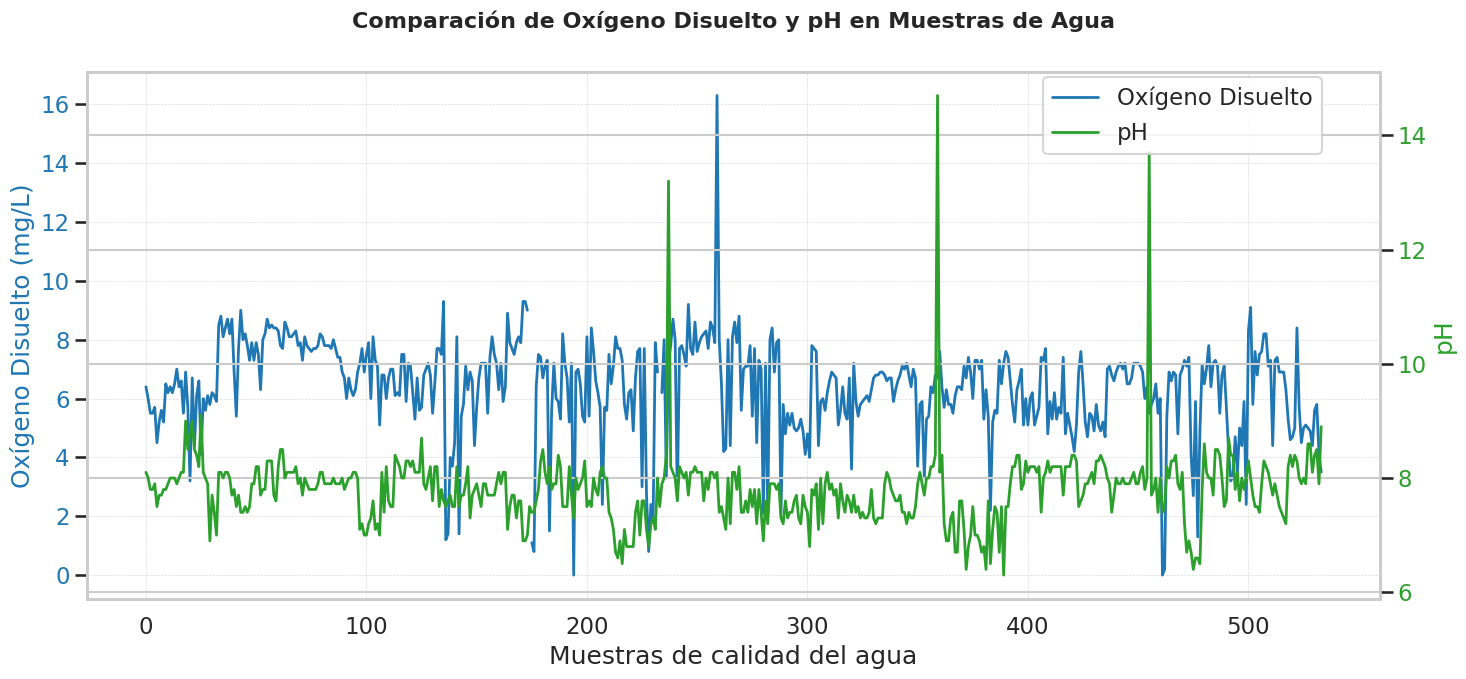

In [93]:
# Grafica de los parametros para conocer sus caracteristicas
# Se define el tamaño de los parametros

tam = len(do_parametro)
fig, ax1 = plt.subplots(figsize=(15, 7), facecolor='white', edgecolor='k')

# Primer eje (DO)
ax1.set_xlabel('Muestras de calidad del agua')
ax1.set_ylabel('Oxígeno Disuelto (mg/L)', color='tab:blue')
ax1.plot(range(tam), do_parametro, color='tab:blue', linestyle='-', linewidth=2, label='Oxígeno Disuelto')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Segundo eje (pH)
ax2 = ax1.twinx()
ax2.set_ylabel('pH', color='tab:green')
ax2.plot(range(tam), PH_parametro, color='tab:green', linestyle='-', linewidth=2, label='pH')
ax2.tick_params(axis='y', labelcolor='tab:green')

# Título y leyenda
fig.suptitle('Comparación de Oxígeno Disuelto y pH en Muestras de Agua', fontsize=16, fontweight='bold')
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))

plt.tight_layout()
plt.show()

### Analisis
Principalmente, se evidencia como el pH tiene la tendencia a mantenerse relativamente creca a 8, esto indica un valor normal de pH, sin embargo hay casos donde este valor se dispara a valores incluso mayores a 14, indicando una alkalinidad excesiva, sin embargo, esto puede causarse a una falla en la toma de muestras.

Por otra parte el DO se mantiene entre 6 y 9 mg/L, un valor que se encuentra en el rango adecuado para el agua, sin embargo, y como pasa con el pH, los valores tienen la tendencia a dispararse en algunas ocasiones, tanto a niveles altos, llegando hasta 16, o balores excesivamente bajos (llegando a 0), lo ideal es mantener un valor similar al promedio. Por igual se puede evidenciar un salto de datos entre las 100 y 200 muestras, posiblemente por la falta de una medición en ese punto



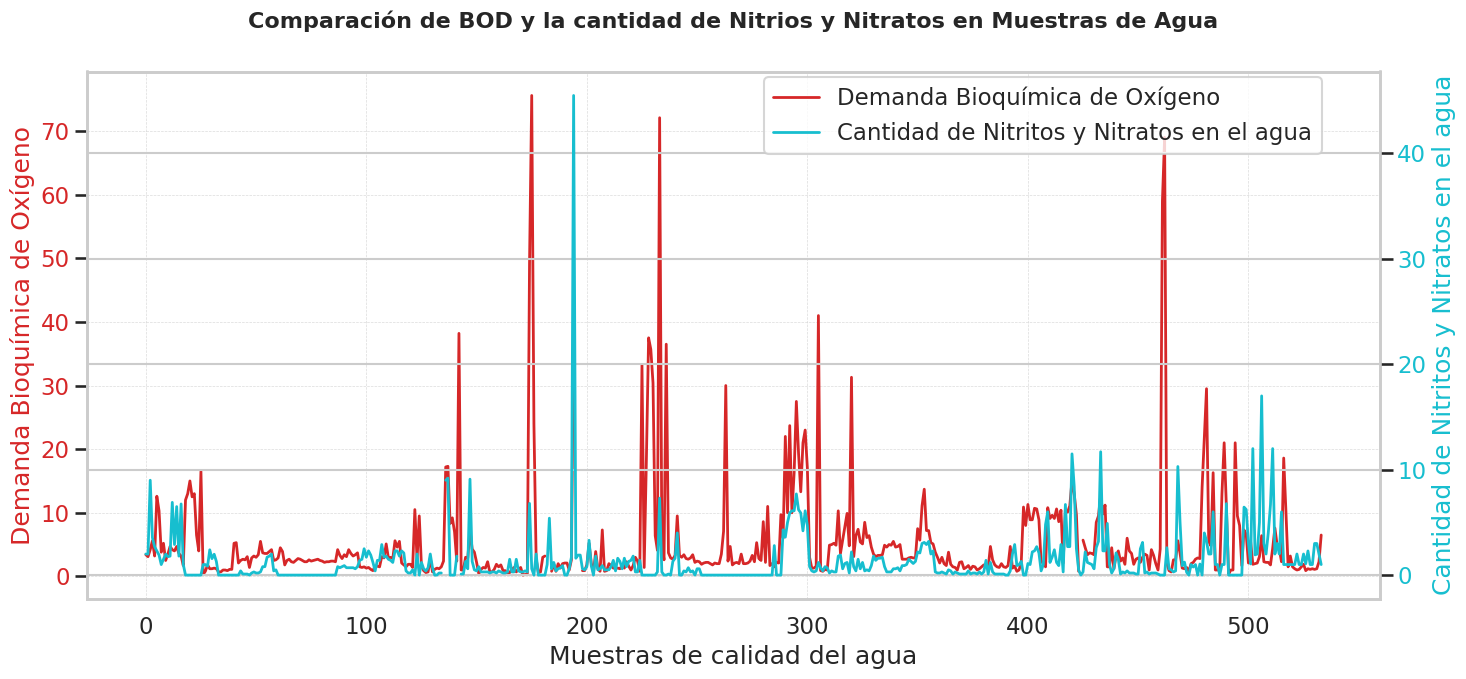

In [94]:
# Grafica de los parametros para conocer sus caracteristicas
# Se define el tamaño de los parametros

tam1 = len(BOD_parametro)
fig, ax1 = plt.subplots(figsize=(15, 7), facecolor='white', edgecolor='k')

# Primer eje (DO)
ax1.set_xlabel('Muestras de calidad del agua')
ax1.set_ylabel('Demanda Bioquímica de Oxígeno', color='tab:red')
ax1.plot(range(tam1), BOD_parametro, color='tab:red', linestyle='-', linewidth=2, label='Demanda Bioquímica de Oxígeno')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Segundo eje (pH)
ax2 = ax1.twinx()
ax2.set_ylabel('Cantidad de Nitritos y Nitratos en el agua', color='tab:cyan')
ax2.plot(range(tam), NN_parametro, color='tab:cyan', linestyle='-', linewidth=2, label='Cantidad de Nitritos y Nitratos en el agua')
ax2.tick_params(axis='y', labelcolor='tab:cyan')

# Título y leyenda
fig.suptitle('Comparación de BOD y la cantidad de Nitrios y Nitratos en Muestras de Agua', fontsize=16, fontweight='bold')
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))

plt.tight_layout()
plt.show()

### Analisis

A nivel de BOD, se puede identificar rangos usualmente entre 1 y 3, con la posibilidad de aumentar drasticamente segun el caso, indicando una calidad de agua comunmente buena. Por otra parte, hay bajos niveles de nitritos y nitratos en el agua, indicando nuevamente una buena calidad de agua dado que habria un menor crecimiento de flora en el agua.


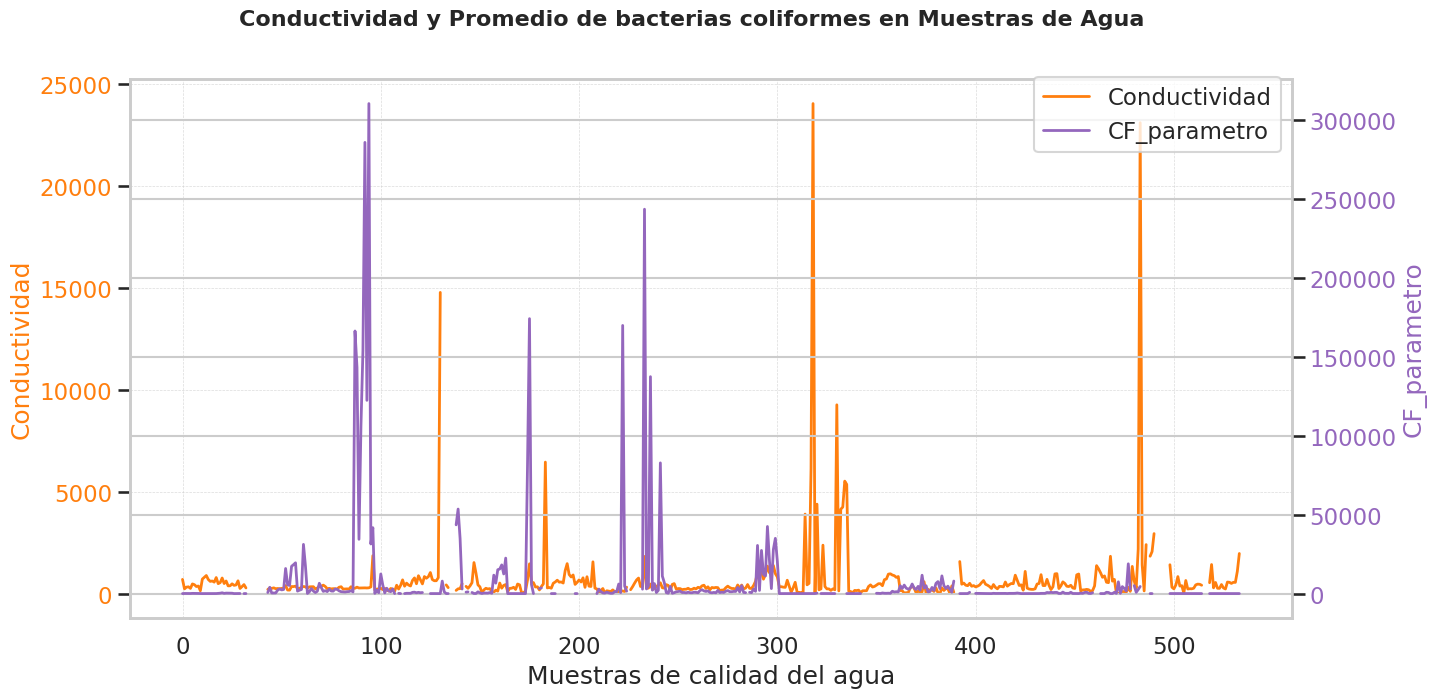

In [95]:
# Grafica de los parametros para conocer sus caracteristicas
# Se define el tamaño de los parametros
tam1 = len(COND_parametro)
fig, ax1 = plt.subplots(figsize=(15, 7), facecolor='white', edgecolor='k')

# Primer eje (DO)
ax1.set_xlabel('Muestras de calidad del agua')
ax1.set_ylabel('Conductividad', color='tab:orange')
ax1.plot(range(tam), COND_parametro, color='tab:orange', linestyle='-', linewidth=2, label='Conductividad')
ax1.tick_params(axis='y', labelcolor='tab:orange')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Segundo eje (pH)
ax2 = ax1.twinx()
ax2.set_ylabel('CF_parametro', color='tab:purple')
ax2.plot(range(tam), FC_parametro, color='tab:purple', linestyle='-', linewidth=2, label='CF_parametro')
ax2.tick_params(axis='y', labelcolor='tab:purple')

# Título y leyenda
fig.suptitle('Conductividad y Promedio de bacterias coliformes en Muestras de Agua', fontsize=16, fontweight='bold')
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))


plt.show()

### Análisis
La conductividad en el agua es generalmente baja, se observa que, como muchos datos anteriores, y demas por venir, los datos tienden a dispararse o ascender de forma extrema cada cierta cantidad de muestras, aunque en general muestre valores adecuados de calidad de agua. Hay una baja cantidad de bacterias coliformes en el agua, con tendencias similares a valores previos, nuevamente indicando un buen estado general del agua en algunos casos, mientras que en otra gran parte, la calidad del agua se dispara en cantidad de bacterias.




#### **Análisis generales**
generalmente, es posible evidenciar como la mayoria de elementos de calidad indirian en teoria unabuena calidad de agua, sin embargo, los disparos de muchos de estos valores posiblemente afectan gravemente al índice final

### **4.3. Filtrados de rango de calidad**
Se requiere el filtrar y realizar rangos para conocer aquellos que cumplan con mtericas adecuadas de calidad de agua

Para esto se utiliza un DataFrame nuevo "df02" con el que se obtienen los valores en rango

In [29]:
#Se requiere hacer una funcion definida por el usuario: que permita definir el rango de la calidad del agua según el PH
#Se crea una columna para los rangos del parametro (segun la  literatura) y basados en el pH del agua
df02 = df01.withColumn("qrPH", F.when((df01.pH>=7)& (df01.pH<=8.5), 100).
                                when(((df01.pH>=6.8) & (df01.pH<6.9)) | ((df01.pH>8.5) & (df01.pH<8.6)), 80).
                                when(((df01.pH>=6.7) & (df01.pH<6.8)) | ((df01.pH>=8.6) & (df01.pH<8.8)), 60).
                                when(((df01.pH>=6.5) & (df01.pH<6.7)) | ((df01.pH>=8.8) & (df01.pH<9.0)), 40).otherwise(0))

In [30]:
#Se crea una columna para los rangos del parametro (segun la  literatura) y basados en el DO del agua
df02 = df02.withColumn("qrDO", F.when((df01.DO>=6), 100).
                      when((df01.DO>=5.1) & (df01.DO<6.0),80).
                      when((df01.DO>=4.1) & (df01.DO<5.0), 60).
                      when((df01.DO>=3.0) & (df01.DO<=4.0), 40).otherwise(0))

In [31]:
#Se crea una columna para los rangos del parametro (segun la  literatura) y basados en la condición del agua
df02 = df02.withColumn("qrCOND", F.when((df01.CONDUCTIVITY>=0.0) & (df01.CONDUCTIVITY<=75.0), 100).
                                when((df01.CONDUCTIVITY>75.0) & (df01.CONDUCTIVITY<=105.0), 80).
                                when((df01.CONDUCTIVITY>150.0) & (df01.CONDUCTIVITY<=225.0), 60).
                                when((df01.CONDUCTIVITY>225.0) & (df01.CONDUCTIVITY<=300.0), 40).otherwise(0))

In [32]:
#Se crea una columna para los rangos del parametro (segun la  literatura) y basados en el BOD del agua
df02 = df02.withColumn("qrBOD", F.when((df01.BOD>=0.0) & (df01.BOD<3.0), 100).
                                when((df01.BOD>=3.0) & (df01.BOD<6.0), 80).
                                when((df01.BOD>=6.0) & (df01.BOD<80.0), 60).
                                when((df01.BOD>=80.0) & (df01.BOD<125.0), 40).otherwise(0))

In [33]:
#Se crea una columna para los rangos del parametro (segun la  literatura) y basados en los niveles de Nitritos y Nitratos del agua
df02 = df02.withColumn("qrNN", F.when((df01.NITRATE_N_NITRITE_N>=0.0) & (df01.NITRATE_N_NITRITE_N<20.0), 100).
                                when((df01.NITRATE_N_NITRITE_N>=20.0) & (df01.NITRATE_N_NITRITE_N<50.0), 80).
                                when((df01.NITRATE_N_NITRITE_N>=50.0) & (df01.NITRATE_N_NITRITE_N<100.0), 60).
                                when((df01.NITRATE_N_NITRITE_N>=100.0) & (df01.NITRATE_N_NITRITE_N<200.0), 40).otherwise(0))

In [34]:
#Se crea una columna para los rangos del parametro (segun la  literatura) y basados en la cantidad de material fecal en el agua
#Rangos generales:
    ## 100: Agua Dulce
    ## 80: Agua moderada
    ## 60: Agua dura
    ## 40: Agua muy dura

df02 = df02.withColumn("qrFecal", F.when((df01.FECAL_COLIFORM>=0.0) & (df01.FECAL_COLIFORM<5.0), 100).
                                when((df01.FECAL_COLIFORM>=5.0) & (df01.FECAL_COLIFORM<50.0), 80).
                                when((df01.FECAL_COLIFORM>=50.0) & (df01.FECAL_COLIFORM<500.0), 60).
                                when((df01.FECAL_COLIFORM>=500.0) & (df01.FECAL_COLIFORM<1000.0), 40).otherwise(0))

**El objeto dataframe df02, contiene hasta ahora todos los calculos y registros sobre los rangos de calidad de agua considerados apropiados**

In [35]:
#A continuación se hace una inspección general del df02, inspeccionando un total de 10 valores iniciales
df02.show(10)

+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+-------+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY| BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|qrPH|qrDO|qrCOND|qrBOD|qrNN|qrFecal|
+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+-------+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|       735.0| 3.4|                2.0|           3.0| 100| 100|     0|   80| 100|    100|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|6.0|8.0|       270.0| 3.1|                2.0|          72.0| 100| 100|    40|   80| 100|     60|
|        2182|GODAVARI RIVER AT...|MAHARASHTRA|25.8|5.5|7.8|       355.0| 4.2|                9.0|          59.0| 100|  80|     0|   80| 100|     60|
|        2179|GODAVARI RIVER AT...|MAHARASHTRA|24.8|5.5|7.8|       371.0| 5.6|               3.55|  

In [36]:
#Se presentan las columnas generadas para df02
df02.columns

['STATION CODE',
 'LOCATIONS',
 'STATE',
 'TEMP',
 'DO',
 'pH',
 'CONDUCTIVITY',
 'BOD',
 'NITRATE_N_NITRITE_N',
 'FECAL_COLIFORM',
 'qrPH',
 'qrDO',
 'qrCOND',
 'qrBOD',
 'qrNN',
 'qrFecal']

## **5. Inicio de calculos de Índice de Calidad**

**Creación de columnas que contengan el índice de Calidad según la referencia bibliografica**

In [129]:
#Se crea un nuevo objeto dataframe "df03" con las nuevas columnas de índice de calidad,
#donde se presentan los valores con sus respectivos valores de índice apropiados
df03 = df02.withColumn("wPH", F.round(df02.qrPH*0.165,3))
df03 = df03.withColumn("wDO", F.round(df03.qrDO*0.281,3))
df03 = df03.withColumn("wCOND", F.round(df03.qrCOND*0.234,3))
df03 = df03.withColumn("wBOD", F.round(df03.qrBOD*0.009,3))
df03 = df03.withColumn("wNN", F.round(df03.qrNN*0.028,3))
df03 = df03.withColumn("wFecal", F.round(df03.qrFecal*0.281,3))

In [38]:
#Se presentan las columnas generadas para el nuevo DataFrame
df03.columns

['STATION CODE',
 'LOCATIONS',
 'STATE',
 'TEMP',
 'DO',
 'pH',
 'CONDUCTIVITY',
 'BOD',
 'NITRATE_N_NITRITE_N',
 'FECAL_COLIFORM',
 'qrPH',
 'qrDO',
 'qrCOND',
 'qrBOD',
 'qrNN',
 'qrFecal',
 'wPH',
 'wDO',
 'wCOND',
 'wBOD',
 'wNN',
 'wFecal']

In [39]:
#Se presentan las 10 primeras filas de datos presentes en el nuevo DataFrame
df03.show(10)

+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+-------+----+-----+-----+----+---+------+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY| BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|qrPH|qrDO|qrCOND|qrBOD|qrNN|qrFecal| wPH|  wDO|wCOND|wBOD|wNN|wFecal|
+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+-------+----+-----+-----+----+---+------+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|       735.0| 3.4|                2.0|           3.0| 100| 100|     0|   80| 100|    100|16.5| 28.1|  0.0|0.72|2.8|  28.1|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|6.0|8.0|       270.0| 3.1|                2.0|          72.0| 100| 100|    40|   80| 100|     60|16.5| 28.1| 9.36|0.72|2.8| 16.86|
|        2182|GODAVARI RIVER AT...|MAHARASHTRA|25.8|5.5|7.8|       355.0| 4.2|       

## **5.1. Calculo del Índice de Calidad del Agua**

    - Se crea la columna WQI: representando el Índice de Calidad, pero la NOTA A RESALTAR es que según la literatura, son muy pocos datos para que refleje un valor confiable. Es decir, que como un estudio ejemplo, NO ES UNA GUIA A TENER EN CUENTA PARA LA VERDADERA CALIDAD DEL AGUA EN INDIA

In [40]:
# Se crea un nuevo DataFrame "df04", que contiene la variable "WQI", que representa el índice de calidad del agua
# WQI consiste en la suma de todos los valores propuestos señalados como wNombre y redondeado
df04 = df03.withColumn("WQI", F.round(df03.wPH+df03.wDO+df03.wCOND+df03.wBOD+df03.wNN+df03.wFecal,3))

In [41]:
# Se muestran los primeros 10 valores con su WQI agregado
df04.show(10)

+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+-------+----+-----+-----+----+---+------+-----+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY| BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|qrPH|qrDO|qrCOND|qrBOD|qrNN|qrFecal| wPH|  wDO|wCOND|wBOD|wNN|wFecal|  WQI|
+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+-------+----+-----+-----+----+---+------+-----+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|       735.0| 3.4|                2.0|           3.0| 100| 100|     0|   80| 100|    100|16.5| 28.1|  0.0|0.72|2.8|  28.1|76.22|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|6.0|8.0|       270.0| 3.1|                2.0|          72.0| 100| 100|    40|   80| 100|     60|16.5| 28.1| 9.36|0.72|2.8| 16.86|74.34|
|        2182|GODAVARI RIVER AT...|MAHARASHTRA|25.8|5.5

### **Intervalos de Índices para WQI**

- Excelente: Agua dulce ***WQI = [100.0 , 75.0]***
- Buena: Agua moderada ***WQI = [75.0 , 50.0]***
- Baja: Agua dura ***WQI = [50.0 , 25.0]***
- Muy_Baja: Agua muy dura ***WQI = [25.0 , 0.0]***
- Inadecuada: Agua residual ***WQI < 0.0***

In [42]:
#Se muestra un resumen de valores de WQI correspondientes
df04.describe("WQI").show()

+-------+-----------------+
|summary|              WQI|
+-------+-----------------+
|  count|              534|
|   mean|57.17340823970035|
| stddev| 16.0478098075452|
|    min|             3.34|
|    max|             94.0|
+-------+-----------------+



In [43]:
#Para comprender mejor el esparcimiento de los datos, es requerido el crear una gráfica, para esto, se inicia con una vista
df04.createOrReplaceTempView("df04_sql")

In [44]:
#Se crea el parametro para la gráfica
WQI_parametro = spark03.sql("Select WQI from df04_sql")
WQI_parametro= WQI_parametro.rdd.map(lambda fila: fila.WQI).collect()

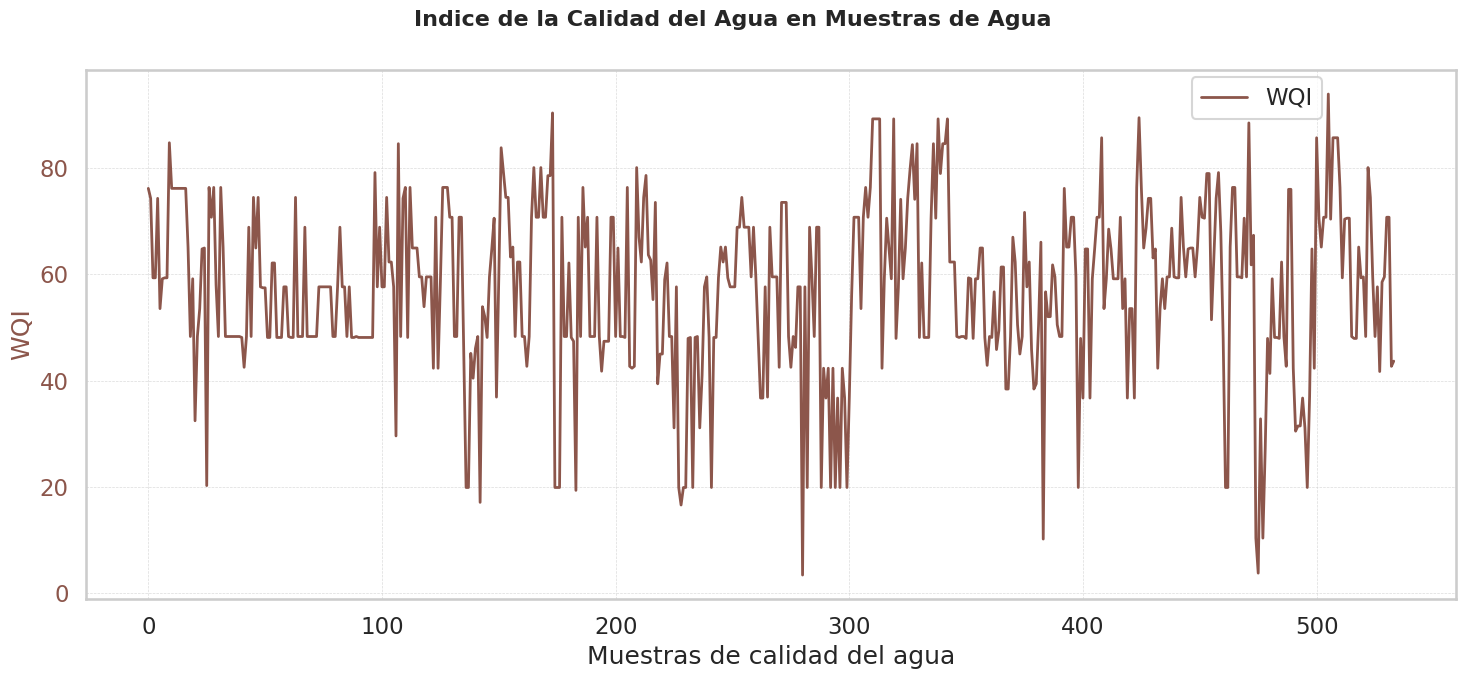

In [96]:
# Grafica de los parametros para conocer sus caracteristicas
# Se define el tamaño de los parametros
fig, ax1 = plt.subplots(figsize=(15, 7), facecolor='white', edgecolor='k')

# Eje Y (WQI)
ax1.set_xlabel('Muestras de calidad del agua')
ax1.set_ylabel('WQI', color='tab:brown')
ax1.plot(range(tam), WQI_parametro, color='tab:brown', linestyle='-', linewidth=2, label='WQI')
ax1.tick_params(axis='y', labelcolor='tab:brown')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Título y leyenda
fig.suptitle('Indice de la Calidad del Agua en Muestras de Agua', fontsize=16, fontweight='bold')
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))

plt.tight_layout()
plt.show()

### Análisis
El índice de calidad tiene la tendencia a encontrarse entre 50 y 70 en puntaje, lo que indica una decente calidad de agua, fuera de que no esta en su mejor estado posible, la calidad del agua es adecuada y se puede considerar como agua moderada, estando entre rangos de "buena" y "baja", no llega a ser excelente, pero tampoco es inutilizable

## **5.2. Union de estados de calidad y filtros**
Se debe de encontrar con los valores que cumplen con un mínimo de calidad, por ello, se debe definir un rango y un estado para la calidad de cada zona por medio de otro DataFrame "df05"

In [125]:
#Se inicia el reconocimiento de estados de calidad por medio de df05 con valores que van en los siguientes rangos:
# 0 =< WQI < 25 - Inadecuada
# 25 =< WQI < 50 - Muy Baja
# 50 =< WQI < 75 - Baja
# 75 =< WQI < 100 - Buena
# 100 =< WQI - Excelente

df05 = df04.withColumn("CALIDAD", F.when((df04.WQI >= 0) & (df04.WQI < 25),'Inadecuada')
    .when((df04.WQI >= 25) & (df04.WQI < 50),'Muy_Baja')
    .when((df04.WQI >= 50) & (df04.WQI < 75),'Baja')
    .when((df04.WQI >= 75) & (df04.WQI < 100),'Buena')
    .otherwise('Excelente'))

In [126]:
# Se muestran los primeros 10 valores con sus atributos de calidad
df05.show(10)

+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+-------+----+-----+-----+----+---+------+-----+-------+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY| BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|qrPH|qrDO|qrCOND|qrBOD|qrNN|qrFecal| wPH|  wDO|wCOND|wBOD|wNN|wFecal|  WQI|CALIDAD|
+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+-------+----+-----+-----+----+---+------+-----+-------+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|       735.0| 3.4|                2.0|           3.0| 100| 100|     0|   80| 100|    100|16.5| 28.1|  0.0|0.72|2.8|  28.1|76.22|  Buena|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|6.0|8.0|       270.0| 3.1|                2.0|          72.0| 100| 100|    40|   80| 100|     60|16.5| 28.1| 9.36|0.72|2.8| 16.86|74.34|   Baja|
|        2182|G

In [48]:
# Con tal de tener un mejor formato para los datos, se forma un nuevo DataFrame "df06" 
# que coloque nombres y titulos en formato para aquelos que se diferencian del resto de atributos
df06 = df05.withColumn('STATE', F.regexp_replace('STATE', 'TAMILNADU', 'TAMIL NADU'))

df06 = df06.withColumn('STATE', F.initcap('STATE'))

df06.show(5)

+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+----+----+------+-----+----+-------+----+-----+-----+----+---+------+-----+--------+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY|BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|qrPH|qrDO|qrCOND|qrBOD|qrNN|qrFecal| wPH|  wDO|wCOND|wBOD|wNN|wFecal|  WQI| CALIDAD|
+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+----+----+------+-----+----+-------+----+-----+-----+----+---+------+-----+--------+
|        1312|GODAVARI AT JAYAK...|Maharashtra|29.2|6.4|8.1|       735.0|3.4|                2.0|           3.0| 100| 100|     0|   80| 100|    100|16.5| 28.1|  0.0|0.72|2.8|  28.1|76.22|Muy_Baja|
|        2177|GODAVARI RIVER NE...|Maharashtra|24.5|6.0|8.0|       270.0|3.1|                2.0|          72.0| 100| 100|    40|   80| 100|     60|16.5| 28.1| 9.36|0.72|2.8| 16.86|74.34|    Baja|
|        2182|G

## **6. Visualización de estados de la india**
 - Se visualizan los estados sobre los datos obtenidos de la Calidad del Agua, es decir, sus etiquetas correspondientes en la zona donde corresponda

In [49]:
# Se divide el mapa en regiones basadas en valores y nombres
colEstado = 'STATE'

valNombres = df05.select(colEstado).distinct().collect()
valNombres = [v[colEstado] for v in valNombres]
# Se muestran los nombres de las regiones
print(valNombres)

['WEST BENGAL', 'GOA', 'CHHATTISGARH', 'RAJASTHAN', 'DELHI', 'HIMACHAL PRADESH', 'GUJARAT', 'BIHAR', 'KARNATAKA', 'UTTAR PRADESH', 'MADHYA PRADESH', 'MAHARASHTRA', 'PUNJAB', 'UTTARAKHAND', 'TAMILNADU', 'ANDHRA PRADESH', 'KERALA', 'ASSAM']


#### **Se cargan los datos de los mapas disponibles**

- Los ficheros comprimidos en formatos "dbf", "prj", "shp" o "shx" se encuentran agrupados en una carpeta "Indian_States" entre los archivos almacenados en el cluster

In [50]:
# Se obtiene la ruta a los datos en el formato "shp"
rutaMapas = "Indian_States/Indian_States.shp"

# Se carga un objeto dataframe "gpd01" de los datos comprimidos de los mapas

gpd01 = gpd.read_file(rutaMapas)

In [51]:
# Se visualiza el tipo dataframe que otorga geopandas 
print(type(gpd01))
# Se muestran las columnas correspondientes al DataFrame
gpd01.columns

<class 'geopandas.geodataframe.GeoDataFrame'>


Index(['st_nm', 'geometry'], dtype='object')

In [52]:
# Se visualizan los nombres de las columnas de los estados "st_nm"
gpd01["st_nm"].unique()

array(['Andaman & Nicobar Island', 'Arunanchal Pradesh', 'Assam', 'Bihar',
       'Chandigarh', 'Chhattisgarh', 'Dadara & Nagar Havelli',
       'Daman & Diu', 'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh',
       'Jammu & Kashmir', 'Jharkhand', 'Karnataka', 'Kerala',
       'Lakshadweep', 'Madhya Pradesh', 'Maharashtra', 'Manipur',
       'Meghalaya', 'Mizoram', 'Nagaland', 'NCT of Delhi', 'Puducherry',
       'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telangana',
       'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal', 'Odisha',
       'Andhra Pradesh'], dtype=object)

In [53]:
# Se eliminan caracteres especiales o irregulares: 
# Se cambian dado a que se supone que los estados del mapa coincidan con los nombres de los estados del DataFrame de datos inicial
gpd02 = gpd01.replace({'Andaman & Nicobar Island' : 'Andaman Nicobar Island',
                       'Dadara & Nagar Havelli' : 'Dadara Nagar Havelli', 
                       'Daman & Diu' : 'Daman Diu', 
                       'Jammu & Kashmir' : 'Jammu Kashmir',
                       'NCT of Delhi' : 'Delhi'})
# Se muestran los estados correspondientes
gpd02['st_nm'].unique


<bound method Series.unique of 0     Andaman Nicobar Island
1         Arunanchal Pradesh
2                      Assam
3                      Bihar
4                 Chandigarh
5               Chhattisgarh
6       Dadara Nagar Havelli
7                  Daman Diu
8                        Goa
9                    Gujarat
10                   Haryana
11          Himachal Pradesh
12             Jammu Kashmir
13                 Jharkhand
14                 Karnataka
15                    Kerala
16               Lakshadweep
17            Madhya Pradesh
18               Maharashtra
19                   Manipur
20                 Meghalaya
21                   Mizoram
22                  Nagaland
23                     Delhi
24                Puducherry
25                    Punjab
26                 Rajasthan
27                    Sikkim
28                Tamil Nadu
29                 Telangana
30                   Tripura
31             Uttar Pradesh
32               Uttarakhand
33          

In [54]:
# Se cambia el nombre en el gpd de la columna "st_nm" a "STATE"
gpd03 = gpd02.rename(columns = {"st_nm" : 'STATE'})

# Se combinan los nombres entre los dos objetos dataframe: map y spark con clave 'STATE'
dfMAP = pd.merge(gpd03, df06.toPandas(), how='outer', on='STATE')

# Se toman los puntos a bajo coste que garantizan estar dentro de la geometria (mapa)
dfMAP['coords'] = dfMAP['geometry'].apply(lambda x:x.representative_point().coords[:])

dfMAP['coords'] = [coords[0] for coords in dfMAP['coords']]

# Se eliminan duplicados

dfMAP = dfMAP.drop_duplicates(subset = 'STATE')

#### **Mapa Inicial de la India**

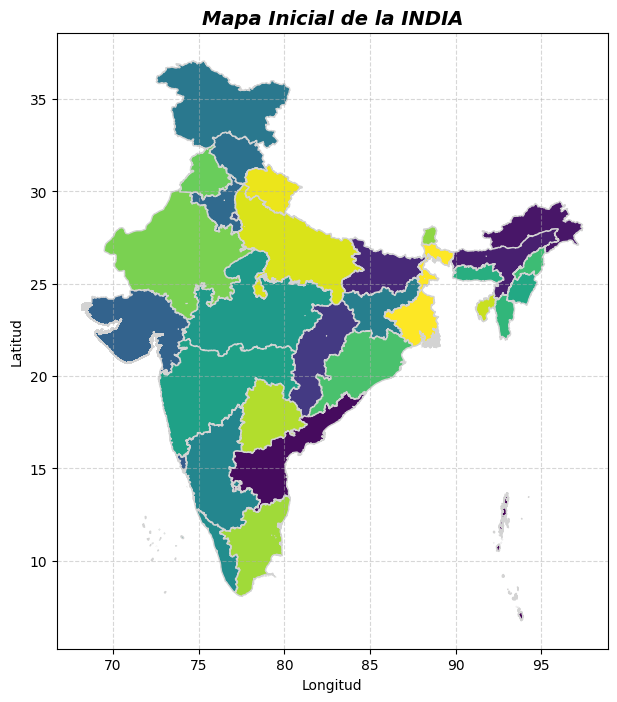

In [55]:
fig, ax = plt.subplots(figsize=(10, 8))
dfMAP.plot(ax=ax, cmap='viridis', edgecolor='lightgrey', missing_kwds={'color':'lightgrey'})
ax.set_title('Mapa Inicial de la INDIA', fontsize=14, fontstyle='italic', fontweight='bold')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.grid(True, linestyle='--', alpha=0.5)
plt.show()

### **6.1. Creación de mapa con valores WQI**

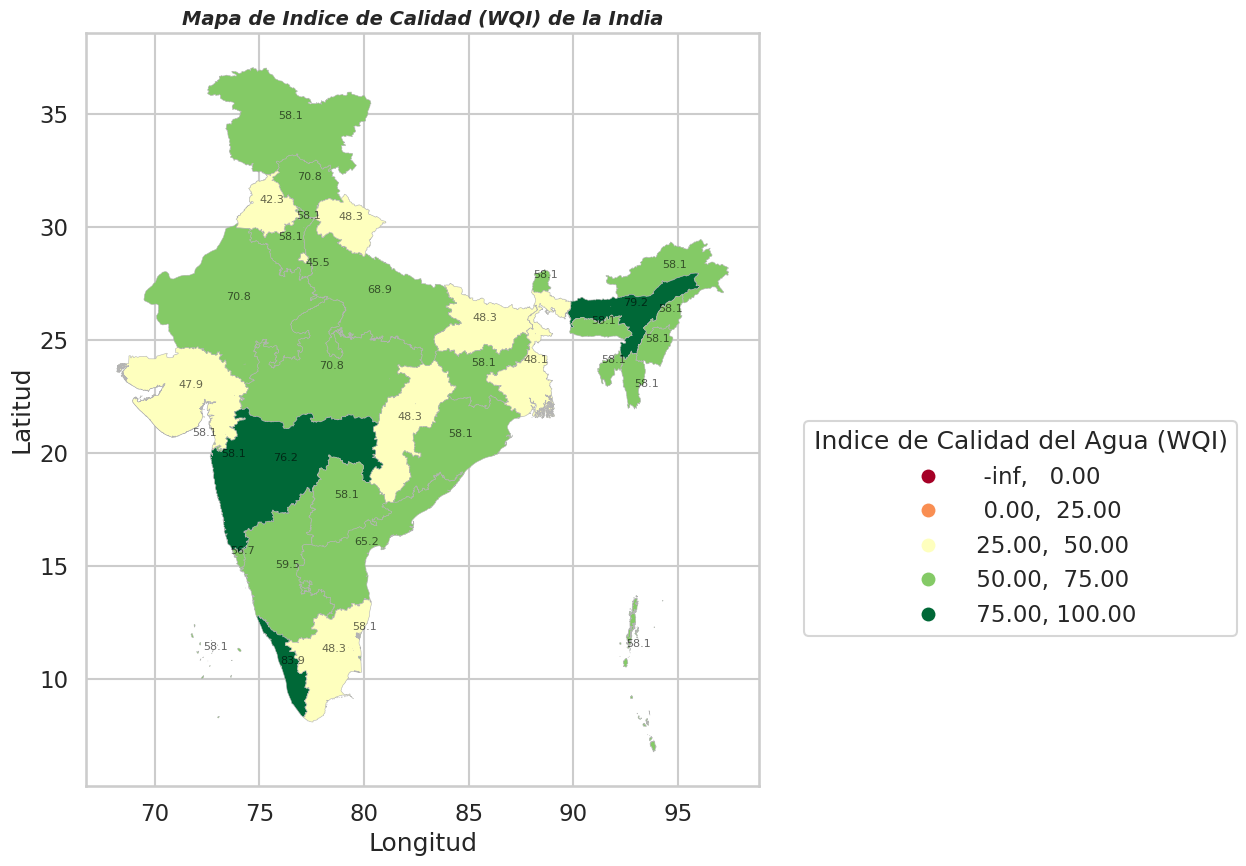

In [127]:
#Se verifica los valores NULOS; en caso de que existan se cambian poor el promedio
#Se toma la ruta corta (la imputacion de valores nulos puede ser mejor tratada)

dfMAP['WQI'] = dfMAP['WQI'].fillna(dfMAP['WQI'].median())

##Configuracion de Estilos para ser usados en la impersion con seaborn
sns.set_context('talk') #puede ser cualquiera
sns.set_style('whitegrid') #Puede ser cualquiera de la biblioteca de estilos de seaborn

#se ajusta el mapa
fig, ax = plt.subplots(figsize=(18,9))
#dibujar el mapa
dfMAP.plot(column='WQI', cmap='RdYlGn',ax=ax, scheme = 'userdefined',
           classification_kwds={'bins': [0,25,50,75,100]},
           legend = True, linewidth=0.4, edgecolor='0.7')
##Ajustar la leyenda
leg = ax.get_legend()
leg.set_title('Indice de Calidad del Agua (WQI)')
leg.set_bbox_to_anchor((1.05,0.5))

frame = leg.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('0.8')

## Se agregan etiquetas sin superposición (tener cuidado con el tamaño del PLOT)
textos = []

for _, row in dfMAP.iterrows():
    if not np.isnan(row['WQI']):
        centroide = row.geometry.centroid
        texto = ax.annotate(f"{row['WQI']:.1f}", xy =(centroide.x, centroide.y),
                           fontsize = 8,color='black',ha='center', alpha = 0.6)
        textos.append(texto)

# AJustar texto de etiquetas
adjust_text(textos, ax = ax, force_points=(0.4,0.4))

## Carpinteria

ax.set_title("Mapa de Indice de Calidad (WQI) de la India", fontsize=14, fontstyle='italic', fontweight='bold')
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")
plt.tight_layout()
plt.show()

### Análisis

Los valores de calidad del agua indican un rango de entre 40 a 80 aproximadamente, siendo desde baja calidad a excelente, no se ven rangos menores de 25, por lo que se concluye nuevamente, y aun mas viendo la distribución en el pais, que la calidad de agua en general es decente.

### **6.2. Histograma de WQI por Estado**

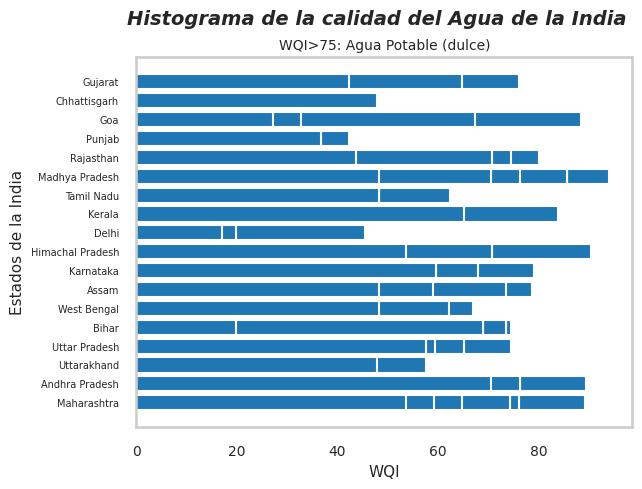

In [128]:
#Para crear el histograma, se genera una vista de df06
df06.createOrReplaceTempView('df06_sql')
#Se seleccionan los nombres de los estados
Estados = spark03.sql('Select STATE from df06_sql')
Estados = Estados.rdd.map(lambda row: row.STATE).collect()

##Seleccionamos los valores de WQI 
wqi = spark03.sql('Select WQI from df06_sql') 
wqi = wqi.rdd.map(lambda row: row.WQI).collect()

##Se grafica el histograma
plt.barh(Estados,wqi)
plt.suptitle("Histograma de la calidad del Agua de la India", fontsize=14, fontstyle='italic', fontweight='bold')
plt.title('WQI>75: Agua Potable (dulce)',fontsize=10)
plt.xlabel('WQI',fontsize=11)
plt.ylabel('Estados de la India', fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=7)
plt.grid()
plt.show()

### Análisis

La mayoria de estados, asi representados por el histograma, muestran valores comunmente por encima de 40, tal como fue demostrado por el mapa y revisiones previas, reforzando aun mas el hecho del buen estado de la calidad del agua

## **7. creación de Modelo: Calidad de agua en India**
 - Se requiere predecir el parametro WQI

In [60]:
#Se requiere predecir el parametro WQI
#Se crea un DF en pandas, un vector a manipular a traves de numpy y columnas de calidad
dfCalidad = df06.select('qrPH','qrDO', 'qrCOND', 'qrBOD', 'qrNN', 'qrFecal')
#Se crea un segund DF en pandas con los valores de WQUI
dfPredecir = df06.select('WQI')

#Se muestran contenidos de ambos DF
dfCalidad.show(5)

dfPredecir.show(5)

+----+----+------+-----+----+-------+
|qrPH|qrDO|qrCOND|qrBOD|qrNN|qrFecal|
+----+----+------+-----+----+-------+
| 100| 100|     0|   80| 100|    100|
| 100| 100|    40|   80| 100|     60|
| 100|  80|     0|   80| 100|     60|
| 100|  80|     0|   80| 100|     60|
| 100|  80|    40|   80| 100|     80|
+----+----+------+-----+----+-------+
only showing top 5 rows

+-----+
|  WQI|
+-----+
|76.22|
|74.34|
|59.36|
|59.36|
|74.34|
+-----+
only showing top 5 rows



In [61]:
# Se separan datos por medio de Scikit-learn
dataTrain, dataTest, predTrain, predTest = train_test_split(dfCalidad.toPandas(), dfPredecir.toPandas(),test_size = 0.2, random_state=1)

In [62]:
#Se muestran los datos separados
print(f"Calidad de datos totales: {df06.count, len(df06.columns)}")
print(f"Calidad de Entrenamiento: {dataTrain.shape}")
print(f"Calidad de Prueba: {dataTest.shape}")
print(f"Calidad de datos Predicción de Entrenamiento: {predTrain.shape}")
print(f"Calidad de datos Predicción de Prueba: {predTest.shape}")

Calidad de datos totales: (<bound method DataFrame.count of DataFrame[STATION CODE: string, LOCATIONS: string, STATE: string, TEMP: float, DO: float, pH: float, CONDUCTIVITY: float, BOD: float, NITRATE_N_NITRITE_N: float, FECAL_COLIFORM: float, qrPH: int, qrDO: int, qrCOND: int, qrBOD: int, qrNN: int, qrFecal: int, wPH: double, wDO: double, wCOND: double, wBOD: double, wNN: double, wFecal: double, WQI: double, CALIDAD: string]>, 24)
Calidad de Entrenamiento: (427, 6)
Calidad de Prueba: (107, 6)
Calidad de datos Predicción de Entrenamiento: (427, 1)
Calidad de datos Predicción de Prueba: (107, 1)


### **7.1. Creación de modelos de entrenamiento**

In [64]:
#Se crea el modelo por medio de Keras
#En un inicio, se crean modelos basados solamente en elementos de Train, en estos se definin los modelos generados

#Se elige un numero de epocas de entrenamiento y lotes
epocas = 200
lote = 85
# Se inicia el modelo con las capas
modelo01 = Sequential()
modelo01.add(Dense(350,input_dim=6, activation='relu'))
modelo01.add(Dense(350, activation='relu'))
modelo01.add(Dense(350, activation='relu'))
modelo01.add(Dense(350, activation='relu'))
modelo01.add(Dense(1, activation='linear'))

In [65]:
#Se genera un segundo modelo con un diferente numero de epocas y lote, junto con un numero distinto forma
epocas2 = 300
lote2 = 95
# Se inicia el modelo con las capas
modelo02 = Sequential()
modelo02.add(Dense(500,input_dim=6, activation='relu'))
modelo02.add(Dense(500, activation='relu'))
modelo02.add(Dense(500, activation='relu'))
modelo02.add(Dense(500, activation='relu'))
modelo02.add(Dense(1, activation='linear'))

In [66]:
# Para optimizar el modelo, se usa el optimizador ADAM
# La compilación se ajusta a la perdida del error cuadratico
keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9,beta_2=0.999,amsgrad=False)
modelo01.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mse'])

In [67]:
# Se realiza la misma optimización con el segundo modelo
keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9,beta_2=0.999,amsgrad=False)
modelo02.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mse'])

In [68]:
#Se muestra un resumen del primer modelo
modelo01.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 350)            │         2,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 350)            │       122,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 350)            │       122,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 350)            │       122,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           351 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 371,351 (1.42 MB)

 Trainable params: 371,351 (1.42 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
#Se muestra un resumen del segundo modelo
modelo02.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 500)            │         3,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 500)            │       250,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 500)            │       250,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 500)            │       250,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 755,501 (2.88 MB)

 Trainable params: 755,501 (2.88 MB)

 Non-trainable params: 0 (0.00 B)

**Un rasgo importante a resaltar, es que en el caso del segundo modelo, el numero de parametros es mayor, lo que implica una posible certeza mayor en los datos obtenidos**

In [70]:
#Se ejecuta el primer modelo, usando los epocas y el lote correspondiente
ejecutarK = modelo01.fit(dataTrain, predTrain, epochs=epocas, batch_size=lote)

Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1649.3330 - mse: 1649.3330
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 143.9561 - mse: 143.9561
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 60.8751 - mse: 60.8751
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.8442 - mse: 18.8442
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 11.7201 - mse: 11.7201 
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.3328 - mse: 5.3328 
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.6383 - mse: 1.6383
Epoch 8/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5426 - mse: 0.5426 
Epoch 9/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3820 - mse: 0.3820
Epoch 10/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2738 - mse: 0.2738 
Epoch 11/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1771 - mse: 0.1771 
Epoch 12/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1295 - mse: 0.1295 
Epoch 13/200
6/6 ━━━━━━━━━━━━━━━━━

In [ ]:
#Se ejecuta el segundo modelo, usando los epocas y el lote correspondiente
ejecutarK2 = modelo02.fit(dataTrain, predTrain, epochs=epocas2, batch_size=lote2)

Epoch 1/300


## **7.2. Modelado de perdidas**

Es importante conocer las perdidas en el análisis de los datos, con tal de conocer un margen de error inicial

In [ ]:
#Se elige el tamaño de la grafica
plt.figure(figsize=(8, 5))
#Se especifica que se requiere el estado de pérdida
loss = ejecutarK.history['loss']
plt.plot(loss)

#Se eligen detalles como titulos, colores, entre otros
plt.title("Pérdida del Modelo por Épocas", fontsize=14, fontstyle='italic', fontweight='bold')
plt.xlabel('Épocas', fontsize=11)
plt.ylabel('Pérdida', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
#Ahora se muestra la pérdida del segundo modelo
#Se elige el tamaño de la grafica
plt.figure(figsize=(8, 5))
#Se especifica que se requiere el estado de pérdida
loss = ejecutarK2.history['loss']
plt.plot(loss)

#Se eligen detalles como titulos, colores, entre otros
plt.title("Pérdida del Modelo por Épocas", fontsize=14, fontstyle='italic', fontweight='bold')
plt.xlabel('Épocas', fontsize=11)
plt.ylabel('Pérdida', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

**Comparaciones y análisis**

Comparando ambas graficas, es posible concluir que ninguno de los modelos sufrio perdidas significativas, y que ambos obtuvieron una cantidad de perdida excedentemente bajo

### **Inicio de predicciones**

In [ ]:
# Se requiere predecir sobre los datos de prueba
predmodelo01_Train = modelo01.predict(dataTrain)

In [181]:
# Se requiere predecir para el segundo modelo por igual
predmodelo02_Train = modelo02.predict(dataTrain)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


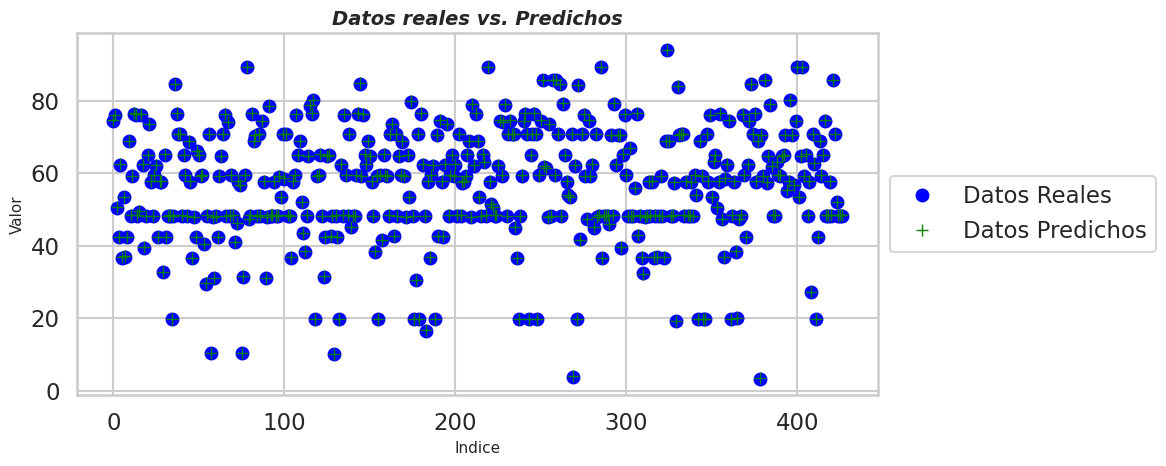

In [111]:
# Se pinta la predicción 
plt.figure(figsize=(12, 5))

# Se definen detalles de datos reales y predichos por cada prueba
plt.plot(range(len(dataTrain)), predTrain, 'bo', label='Datos Reales')
plt.plot(range(len(predmodelo01_Train)), predmodelo01_Train, 'g+', label='Datos Predichos')

# Se aclaran mas detalles respecto al estilo de la grafica
plt.title("Datos reales vs. Predichos", fontsize=14, fontstyle='italic', fontweight='bold')
plt.xlabel("Indice",fontsize=11)
plt.ylabel("Valor",fontsize=11)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

### Análisis

Tras entrenar el modelo, y comparando con los datos de prediccion representando los datos reales, es posible evidenciar un apego o semejanza bastante fuerte con los datos predichos, indicando un buen funcionamiento del modelo.

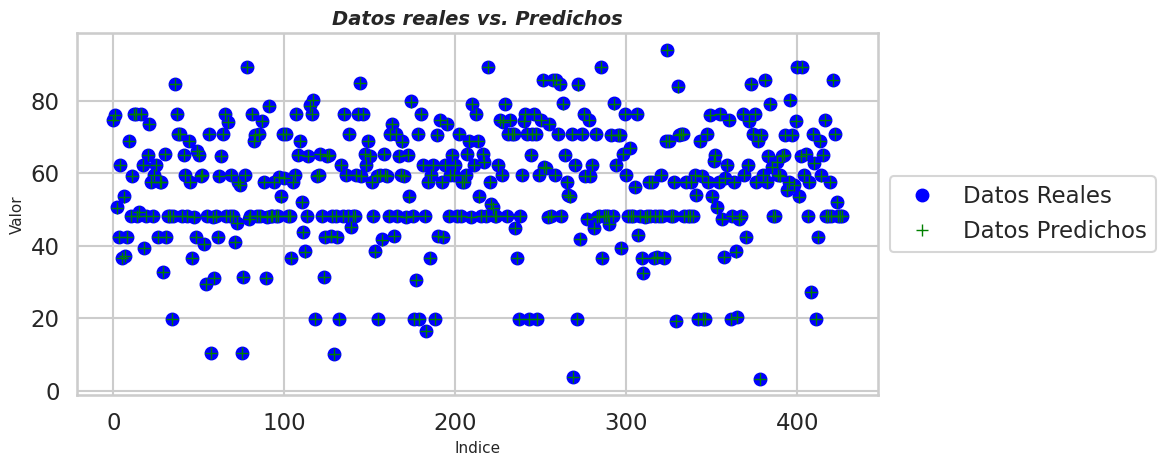

In [112]:
# Se pinta la predicción del segundo modelo
plt.figure(figsize=(12, 5))

# Se definen detalles de datos reales y predichos por cada prueba
plt.plot(range(len(dataTrain)), predTrain, 'bo', label='Datos Reales')
plt.plot(range(len(predmodelo02_Train)), predmodelo02_Train, 'g+', label='Datos Predichos')

# Se aclaran mas detalles respecto al estilo de la grafica
plt.title("Datos reales vs. Predichos", fontsize=14, fontstyle='italic', fontweight='bold')
plt.xlabel("Indice",fontsize=11)
plt.ylabel("Valor",fontsize=11)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

### Análisis

Tal como en el caso anterior, los datos predichos se asemejan bastante a los datos reales ofrecidos para predicciones en entrenamiento, indicando que este segundo modelo es por igual acertado

### **7.2. Uso de modelos de prueba**

Dados los modelos ya entrenados, es momento de realizar predicciones utilizando los valores de prueba, cabe recalcar que no se vuelven a realizar ejecuciones con los datos de prueba, dado a que estos podrian afectar el estado final de las predicciones

In [198]:
# Se requiere predecir sobre los datos del entrenamiento
predmodelo03_Test = modelo01.predict(dataTest)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [194]:
# Se requiere predecir sobre los datos del entrenamiento por igual con el segundo modelo
predmodelo04_Test = modelo02.predict(dataTest)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


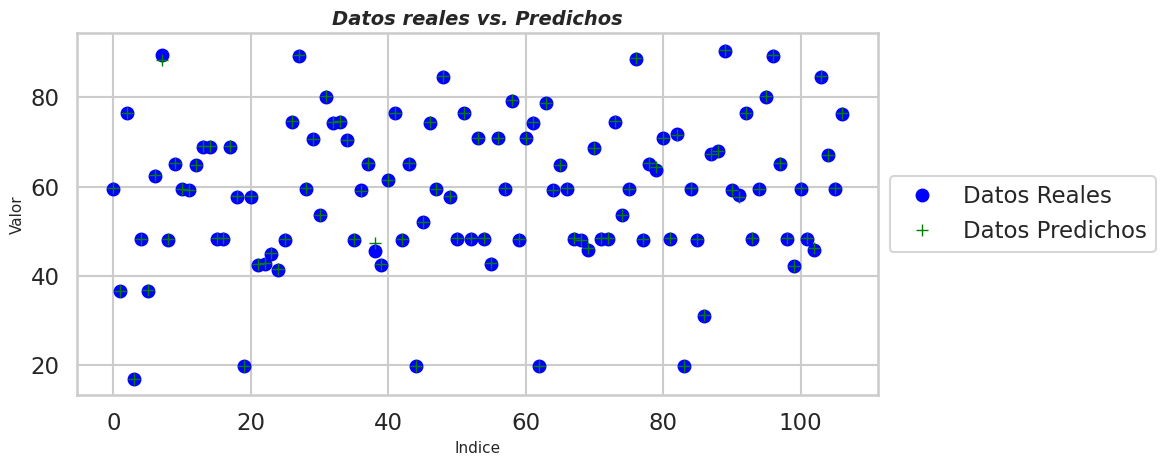

In [109]:
# Se pinta la predicción del primer modelo
plt.figure(figsize=(12, 5))

# Se definen detalles de datos reales y predichos por cada prueba
plt.plot(range(len(dataTest)), predTest, 'bo', label='Datos Reales')
plt.plot(range(len(predmodelo03_Test)), predmodelo03_Test, 'g+', label='Datos Predichos')

# Se aclaran mas detalles respecto al estilo de la grafica
plt.title("Datos reales vs. Predichos", fontsize=14, fontstyle='italic', fontweight='bold')
plt.xlabel("Indice", fontsize=11)
plt.ylabel("Valor",fontsize=11)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

### Análisis

Tras utilizar modelos de prueba, y asi, probando realmente las capacidades del modelo principal, se ve como en su gran mayoria los resultados son precisos y acretados, indicando un correcto funcionamiento del modelo tras su entrenamiento.

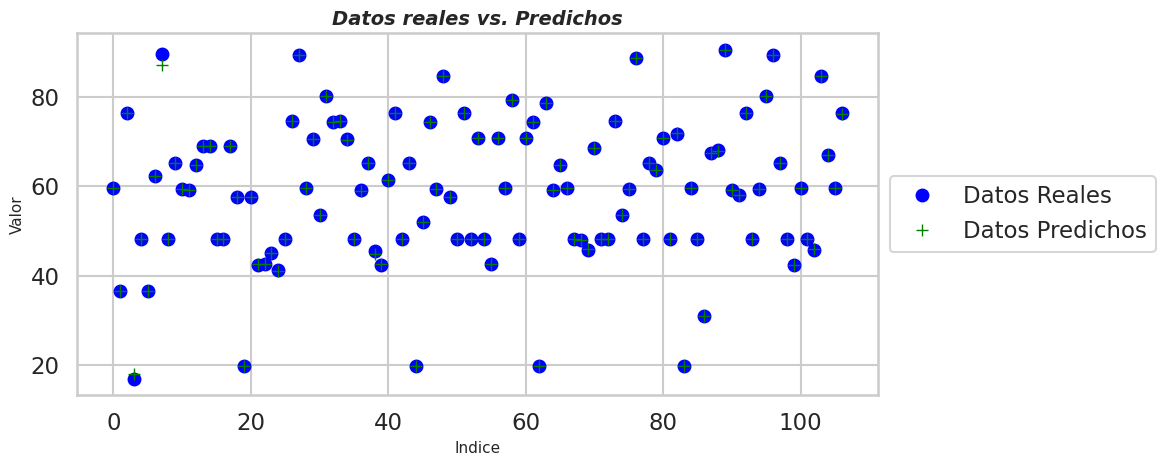

In [110]:
# Se pinta la predicción del segundo modelo
plt.figure(figsize=(12, 5))

# Se definen detalles de datos reales y predichos por cada prueba
plt.plot(range(len(dataTest)), predTest, 'bo', label='Datos Reales')
plt.plot(range(len(predmodelo04_Test)), predmodelo04_Test, 'g+', label='Datos Predichos')

# Se aclaran mas detalles respecto al estilo de la grafica
plt.title("Datos reales vs. Predichos", fontsize=14, fontstyle='italic', fontweight='bold')
plt.xlabel("Indice", fontsize=11)
plt.ylabel("Valor",fontsize=11)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

### Análisis

Nuevamente, se muestra como el modelo secundario llega a acretar en un gran numero de ocasiones, sin embargo, no es 100% preciso, aunque sus fallas no sean mayores.

Por lo tanto, es necesario validar la certeza de los modelos mediante análisis numericos

## **8. Análisis de certeza**

Se desea analizar que tan certero es el modelo de predicción a la hora de realizar sus predicciones, por ello, se cuenta con revisiones para modelos de regresión

In [130]:
# Se importan librerias de análisis para certeza
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Se utiliza numpy para trabajar con los resultados del modelo
import numpy as np

In [131]:
# Se definen los datos reales y predecidos en variables
y_true = predTest['WQI']
y_pred = predmodelo03_Test.flatten()

In [132]:
# Se calculan las metricas de certeza para modelos de regresión
EAP = mean_absolute_error(y_true, y_pred) #Promedio de error absoluto
EAC = mean_squared_error(y_true, y_pred) #Error absoluto cuadrado
rmse = np.sqrt(EAC) #Raiz de Error absoluto cuadrado
r2 = r2_score(y_true, y_pred) #Determinación

print(f"MAE  = {EAP:.3f}")   # Error absoluto medio
print(f"MSE  = {EAC:.3f}")   # Error cuadrático medio
print(f"RMSE = {rmse:.3f}")  # Raíz del error cuadrático medio
print(f"R²   = {r2:.3f}")    # Coeficiente de determinación

MAE  = 0.170
MSE  = 0.071
RMSE = 0.267
R²   = 1.000


## **Análisis de resultados de precisión**

Considerando los resultados de las metricas para confirmar la certeza del modelo, es posible notar su alta calidad a la hora de realizar predicciones, los resultados numericos indican valores excedentemente acertados y apegados a lo que son los valores reales, esto también es posible evidenciarlo en las graficas de resultados, donde las predicciones encajan casi a la perfección con los datos reales, con mínima variación entre estos.

Esto generalmente indica, mediante por ejemplo MAE  que los datos en promedio se equivocan en valores menores, y no existen erroes graves (visto por el MSE). Es posible que los datos de prueba se asemejen mucho a los datos de entrenamiento, provocando resultados de este estilo, sin embargo, al ser diferentes de los datos de entrenamiento, se considera a los modelos efectivos y precisos.

## **Análisis de Resultados**
### Resultados de modelos
Se puede evidenciar como el entrenamiento inicial del modelo funciona correctamente, esto dado que al usar variables de prueba en lugar de predicción, el modelo fue capaz de realizar predicciones casi identicas a valores reales, aproximándose a las predicciones generadas con más datos cuando se utilizaron variables de predicción.

### Resultados de Índices de Calidad
Se observa como los niveles de calidad del agua se aproximan o rodean a valores entre 40 y 80 de calidad, lo que indica una calidad del agua suficiente, aunque no recomendada para consumo, dado a que se ubican en valores superiores a 40, indican que la calidad de agua raspa lo potable en algunos casos, y en otros se presenta mas prometedora. Cabe recalcar que la cantidad de datos es realmente baja para realizar una predicción o estimación definitiva, por lo que estos resultados no deben ser usados como guía para medir la calidad real del agua en India.

Se puede evidenciar, por medio de tanto el mapa con rangos, como con el histograma, que los estados del país tieneden a contar con agua clasificada como buena, no en la mejor condición posible, pero no llegando a valores demasiado bajos.

### Resultados de predicciones 
Tras encontrar los valores los resultados de predicciones indican la posibilidad de que los datos reales de calidad de agua sean similares a los datos estimados en un inicio, sin embargo la predicción queda corta por la pequeña cantidad de datos, sin embargo es un buen inicio para un verdadero análisis de calidad que ofrezca resultados más similares al caso real.


## **Conclusiones y Observaciones**

Guiandose solamente por los datos otorgados y utilizados para el análisis, se puede concluir respecto al estado general de la calidad del agua en India. La calidad del agua, segun el Índice de Calidad de agua usado como referencia, indica valores medios y llegando a altas, y apropiados en su mayoria, para el consumo humano y otros usos, esto dado que los valores son bastante elevados, e indican pocos problemas con el estado del agua dulce en el país. Desde pH medios, condiciones de contaminación medios o cantidades de bacterias no excesivas, se ve un general buen estado de la calidad del agua en el país.

Especificando los estados que se encuentran en menor problema, es posible notar que tanto Madhya Pradesh, como Himachal Pradesh son los estados con mejores condiciones, aunque todos los estados cumplen con un WQI que indica un estado decente por lo mucho, por lo que realmente nignuno de los estados estaria en grandes dificultades con agua potable. Los estados en peores condiciones son Punjab y Delhi, estados que obtienen niveles mas cercanos a 40, donde el consumo de agua no es recomendable, y menos aceptable en comparación con estados vecinos.

Se resalta una vez mas que estos datos no son una guia definitiva, sin embargo, la creación de modelos de predicción permite estimar, con cierto grado de exactitud y precisión el posible caso real de calidad de agua en el país, igualmente se recomienda el realizar análisis a futuro y de ser posible, con una mayor cantidad de datos. Es notable como, y considerando el estado actual de la calidad de agua en el pais, los valores son bastante distintos, nuevamente, esto se puede basar en la corta cantidad de datos

## Referencias
 - "Water Quality - Science, Assessments and Policy" [Kevin Summers] - https://www.intechopen.com/chapters/69568
 - U.S. Environmental Protection Agency - https://www.epa.gov/salish-sea/freshwater-quality